# Bloco 0: Instalação de bibliotecas (executar se necessário no ambiente Colab)

In [ ]:
!pip install unidecode
!pip install category_encoders
!pip install imbalanced-learn
!pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.1 MB/s eta 0:00:00


# Bloco 1: Configurações e Bibliotecas

In [ ]:
# Bloco 1: Configurações e Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from itertools import product
from unidecode import unidecode
import category_encoders as ce
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc, f1_score, make_scorer,
    recall_score, fbeta_score, precision_score
)
from imblearn.over_sampling import SMOTE
import joblib

plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
sns.set_palette("viridis")
pd.options.display.float_format = '{:,.2f}'.format
print("Bloco 1: Configurações e bibliotecas carregadas.")
print("-" * 50)

Bloco 1: Configurações e bibliotecas carregadas.
--------------------------------------------------


# Bloco 2: Carregamento do Dataset Enriquecido e Definição de Funções Auxiliares

In [ ]:
print("\nBloco 2: Carregamento do Dataset Enriquecido e Definição de Funções Auxiliares.")
caminho_dataset_enriquecido_inmet = 'dataset_SP_2022_completo_com_inmet.csv'
try:
    df_model = pd.read_csv(caminho_dataset_enriquecido_inmet, sep=';', decimal='.')
    print(f"Dataset '{caminho_dataset_enriquecido_inmet}' carregado. Shape: {df_model.shape}")
except FileNotFoundError:
    print(f"ERRO: Arquivo '{caminho_dataset_enriquecido_inmet}' não encontrado. Execute o script 'preparar_dados_meteo.py' primeiro.")
    raise

df_model['data'] = pd.to_datetime(df_model['data'])
df_model.sort_values(by=['municipio', 'data'], inplace=True)

def criar_lags_features(df, group_col, target_cols, lags, data_col='data'):
    df_lagged = df.copy()
    df_lagged[data_col] = pd.to_datetime(df_lagged[data_col])
    df_lagged = df_lagged.sort_values(by=[group_col, data_col])
    for col in target_cols:
        if col not in df_lagged.columns:
            # print(f"  Aviso em criar_lags_features: Coluna '{col}' não encontrada. Pulando.") #debug
            continue
        for lag in lags:
            df_lagged[f'{col}_lag{lag}'] = df_lagged.groupby(group_col)[col].shift(lag)
    return df_lagged

def criar_rolling_mean_features(df, group_col, target_cols, windows, data_col='data', min_periods=1):
    df_rolled = df.copy()
    df_rolled[data_col] = pd.to_datetime(df_rolled[data_col])
    df_rolled = df_rolled.sort_values(by=[group_col, data_col])
    for col in target_cols:
        if col not in df_rolled.columns:
            # print(f"  Aviso em criar_rolling_mean_features: Coluna '{col}' não encontrada. Pulando.") #debug
            continue
        for window in windows:
            df_rolled[f'{col}_roll_mean{window}'] = df_rolled.groupby(group_col)[col].shift(1).rolling(window=window, min_periods=min_periods).mean()
    return df_rolled

def calcular_dias_secos_consecutivos(df, group_col, precip_col, data_col='data', limiar_chuva=0.1):
    df_sorted = df.copy()
    df_sorted[data_col] = pd.to_datetime(df_sorted[data_col])
    df_sorted = df_sorted.sort_values(by=[group_col, data_col])
    if precip_col not in df_sorted.columns:
        print(f"AVISO em dias_secos: Coluna '{precip_col}' não encontrada. Coluna 'dias_secos_consecutivos' será preenchida com 0.")
        df_sorted['dias_secos_consecutivos'] = 0
        return df_sorted
    df_sorted['dia_seco_flag'] = (df_sorted[precip_col].fillna(999) <= limiar_chuva).astype(int)
    df_sorted['bloco_id'] = (df_sorted['dia_seco_flag'] != df_sorted.groupby(group_col)['dia_seco_flag'].shift(1)).cumsum()
    df_sorted['dias_secos_consecutivos'] = df_sorted.groupby([group_col, 'bloco_id'])['dia_seco_flag'].cumsum()
    df_sorted.loc[df_sorted['dia_seco_flag'] == 0, 'dias_secos_consecutivos'] = 0
    df_sorted.drop(columns=['dia_seco_flag', 'bloco_id'], inplace=True, errors='ignore')
    # print(f"Feature 'dias_secos_consecutivos' criada/atualizada usando '{precip_col}'.") #debug
    return df_sorted

def ensure_series_for_fwi(df_series_or_none, fallback_value, index_ref):
    if isinstance(df_series_or_none, pd.Series):
        return df_series_or_none.fillna(fallback_value)
    return pd.Series([fallback_value] * len(index_ref), index=index_ref, dtype=float)

print("Bloco 2: Carregamento e funções auxiliares definidos.")


Bloco 2: Carregamento do Dataset Enriquecido e Definição de Funções Auxiliares.
Dataset 'dataset_SP_2022_completo_com_inmet.csv' carregado. Shape: (226665, 78)
Bloco 2: Carregamento e funções auxiliares definidos.


# Bloco 3: Engenharia de Features

In [ ]:
print("\nBloco 3: Engenharia de Features.")
# print(f"Colunas no início do Bloco 3: {df_model.columns.tolist()}") #debug

colunas_para_imputacao_inicial = [
    'numero_dias_sem_chuva_first', 'precipitacao_sum', 'risco_fogo_mean',
    'frp_sum', 'frp_mean', 'frp_max',
    'precip_total_dia_mm', 'temp_media_dia_C', 'temp_max_dia_C',
    'temp_min_dia_C', 'umidade_media_dia_perc',
    'umidade_min_dia_perc', 'vento_vel_media_dia_ms'
]
# print(f"Imputando NaNs nas colunas base e INMET...") #debug
for col in colunas_para_imputacao_inicial:
    if col in df_model.columns and df_model[col].isnull().any():
        fill_val = np.nan
        if 'precip' in col or 'frp' in col: fill_val = 0.0
        elif 'temp' in col: fill_val = df_model[col].median()
        elif 'umidade' in col: fill_val = df_model[col].median()
        elif 'vento' in col: fill_val = df_model[col].median()
        else: fill_val = df_model[col].median()
        if pd.isna(fill_val):
            if 'precip' in col or 'frp' in col: fill_val = 0.0
            elif 'temp' in col: fill_val = 25.0
            elif 'umidade' in col: fill_val = 60.0
            elif 'vento' in col: fill_val = 2.0
            else: fill_val = 0.0
        df_model[col] = df_model[col].fillna(fill_val)

lags_a_criar = [1, 3, 7]
windows_a_criar = [3, 7, 15]
novas_features_lags_rollings = []
cols_meteo_inmet_para_lagroll = [
    'precip_total_dia_mm', 'temp_media_dia_C', 'temp_max_dia_C',
    'temp_min_dia_C', 'umidade_media_dia_perc',
    'umidade_min_dia_perc', 'vento_vel_media_dia_ms'
]
cols_focos_originais_para_lagroll = [
    'numero_dias_sem_chuva_first', 'risco_fogo_mean', 'precipitacao_sum'
]
cols_frp_base_para_lagroll = ['frp_sum', 'frp_mean', 'frp_max']
colunas_para_lags_e_rollings_final = []
for c_list in [cols_meteo_inmet_para_lagroll, cols_focos_originais_para_lagroll, cols_frp_base_para_lagroll]:
    for col_base in c_list:
        if col_base in df_model.columns: colunas_para_lags_e_rollings_final.append(col_base)
colunas_para_lags_e_rollings_final = sorted(list(set(colunas_para_lags_e_rollings_final)))
# print(f"Colunas para Lags/Rollings: {colunas_para_lags_e_rollings_final}") #debug

if colunas_para_lags_e_rollings_final:
    df_model = criar_lags_features(df_model, 'municipio', colunas_para_lags_e_rollings_final, lags_a_criar)
    df_model = criar_rolling_mean_features(df_model, 'municipio', colunas_para_lags_e_rollings_final, windows_a_criar)
    for col_base in colunas_para_lags_e_rollings_final:
        for lag in lags_a_criar: novas_features_lags_rollings.append(f'{col_base}_lag{lag}')
        for window in windows_a_criar: novas_features_lags_rollings.append(f'{col_base}_roll_mean{window}')
    novas_features_lags_rollings = list(set(f for f in novas_features_lags_rollings if f in df_model.columns))
    print(f"{len(novas_features_lags_rollings)} features de lag/rolling criadas.")

novas_features_dias_secos = []
col_precip_dias_secos = 'precip_total_dia_mm' if 'precip_total_dia_mm' in df_model.columns else 'precipitacao_sum'
if col_precip_dias_secos in df_model.columns:
    df_model = calcular_dias_secos_consecutivos(df_model, 'municipio', col_precip_dias_secos)
    if 'dias_secos_consecutivos' in df_model.columns:
        novas_features_dias_secos.append('dias_secos_consecutivos')

novas_features_interacao = []
if 'dias_secos_consecutivos' in df_model.columns and 'umidade_min_dia_perc_lag1' in df_model.columns:
    df_model['dias_secos_X_umidade_baixa_lag1'] = df_model['dias_secos_consecutivos'] * (100 - df_model['umidade_min_dia_perc_lag1'].fillna(70)) # fillna para umidade se lag for NaN
    novas_features_interacao.append('dias_secos_X_umidade_baixa_lag1')
    print("Feature 'dias_secos_X_umidade_baixa_lag1' criada.")

if 'dias_secos_consecutivos' in df_model.columns and 'risco_fogo_mean_lag1' in df_model.columns:
    df_model['dias_secos_X_risco_fogo_lag1'] = df_model['dias_secos_consecutivos'] * df_model['risco_fogo_mean_lag1'].fillna(0.5) # fillna para risco se lag for NaN
    novas_features_interacao.append('dias_secos_X_risco_fogo_lag1')
    print("Feature 'dias_secos_X_risco_fogo_lag1' criada.")


novas_features_fwi = []
idx_ref = df_model.index
temp_max_fwi = ensure_series_for_fwi(df_model.get('temp_max_dia_C_lag1'), 25.0, idx_ref)
umidade_min_fwi = ensure_series_for_fwi(df_model.get('umidade_min_dia_perc_lag1'), 70.0, idx_ref)
vento_fwi = ensure_series_for_fwi(df_model.get('vento_vel_media_dia_ms_lag1'), 2.0, idx_ref)
temp_media_fwi = ensure_series_for_fwi(df_model.get('temp_media_dia_C_lag1'), 20.0, idx_ref)
umidade_media_fwi = ensure_series_for_fwi(df_model.get('umidade_media_dia_perc_lag1'), 60.0, idx_ref)
precip_lag1_fwi = ensure_series_for_fwi(df_model.get(f'{col_precip_dias_secos}_lag1'), 0.0, idx_ref)
precip_roll7_fwi = ensure_series_for_fwi(df_model.get(f'{col_precip_dias_secos}_roll_mean7'), 0.0, idx_ref)
precip_roll15_fwi = ensure_series_for_fwi(df_model.get(f'{col_precip_dias_secos}_roll_mean15'), 0.0, idx_ref)
dias_secos_fwi = ensure_series_for_fwi(df_model.get('dias_secos_consecutivos'), 0.0, idx_ref)

df_model['ffmc_proxy'] = (temp_max_fwi / 30.0) + ((100.1 - umidade_min_fwi) / 50.0) - (precip_lag1_fwi / 10.0)
novas_features_fwi.append('ffmc_proxy')
df_model['dmc_proxy'] = (temp_media_fwi / 20.0) + ((100.1 - umidade_media_fwi) / 60.0) - (precip_roll7_fwi / 5.0)
novas_features_fwi.append('dmc_proxy')
df_model['dc_proxy'] = (dias_secos_fwi / 10.0) - (precip_roll15_fwi / 20.0)
novas_features_fwi.append('dc_proxy')
df_model['isi_proxy'] = vento_fwi * np.exp(0.05 * (df_model['ffmc_proxy'].fillna(0)))
novas_features_fwi.append('isi_proxy')
df_model['bui_proxy'] = (0.8 * df_model['dmc_proxy'].fillna(0) + 0.2 * df_model['dc_proxy'].fillna(0)).clip(lower=0)
novas_features_fwi.append('bui_proxy')
fwi_b_calc = 0.1 * df_model['isi_proxy'].fillna(0) * df_model['bui_proxy'].fillna(0)
df_model['fwi_proxy_final'] = np.where(fwi_b_calc <=1, fwi_b_calc, np.exp(2.72 * (0.434 * np.log(np.maximum(fwi_b_calc, 1e-9)))**0.647 ) )
novas_features_fwi.append('fwi_proxy_final')
print(f"{len(novas_features_fwi)} features FWI-like proxies criadas/atualizadas.")
# print("Describe das FWI-like proxies PÓS criação:") #debug
# print(df_model[novas_features_fwi].describe()) #debug
print("Fim da Engenharia de Features")



Bloco 3: Engenharia de Features.
78 features de lag/rolling criadas.
Feature 'dias_secos_X_umidade_baixa_lag1' criada.
Feature 'dias_secos_X_risco_fogo_lag1' criada.
6 features FWI-like proxies criadas/atualizadas.
Fim da Engenharia de Features


# Bloco 4: Pré-processamento para Modelagem

In [ ]:
print("\nBloco 4: Pré-processamento para Modelagem.")
data_divisao = pd.to_datetime('2022-10-01')
treino_df = df_model[df_model['data'] < data_divisao].copy()
teste_df = df_model[df_model['data'] >= data_divisao].copy()
print(f"Divisão treino/teste: {len(treino_df)} treino, {len(teste_df)} teste.")

mapbiomas_cols_prop_modelo = [col for col in treino_df.columns if col.startswith('mapbiomas_class_') and col.endswith('_prop')]
colunas_estaticas_modelo = []
if 'id_area_industrial_agg' in treino_df.columns and treino_df['id_area_industrial_agg'].nunique() > 1:
    colunas_estaticas_modelo.append('id_area_industrial_agg')

features_para_modelo_lista = (
    [f for f in novas_features_lags_rollings if f in treino_df.columns] +
    [f for f in novas_features_dias_secos if f in treino_df.columns] +
    [f for f in novas_features_fwi if f in treino_df.columns] +
    [f for f in novas_features_interacao if f in treino_df.columns] +
    [f for f in mapbiomas_cols_prop_modelo if f in treino_df.columns] +
    colunas_estaticas_modelo
)
features_para_modelo_lista = sorted(list(set(features_para_modelo_lista)))

imputadores_finais = {}
for col in features_para_modelo_lista:
    if col in treino_df.columns and treino_df[col].isnull().any():
        imputer = SimpleImputer(strategy='median')
        treino_df.loc[:, col] = imputer.fit_transform(treino_df[[col]])
        if col in teste_df.columns:
            teste_df.loc[:, col] = imputer.transform(teste_df[[col]])
        imputadores_finais[col] = imputer

encoder_target_municipio = ce.TargetEncoder(cols=['municipio'], smoothing=30.0, min_samples_leaf=10)
treino_df['municipio_encoded'] = encoder_target_municipio.fit_transform(treino_df['municipio'], treino_df['ocorreu_incendio'])
teste_df['municipio_encoded'] = encoder_target_municipio.transform(teste_df['municipio'])
media_target_treino = treino_df['ocorreu_incendio'].mean()
teste_df.loc[:, 'municipio_encoded'] = teste_df['municipio_encoded'].fillna(media_target_treino)

colunas_modelo_final = features_para_modelo_lista + ['municipio_encoded']
colunas_a_nao_usar_como_feature = [
    'data', 'municipio', 'GEOCODE', 'codigo_estacao_proxima', 'mapbiomas_area_total_calc_km2',
    'numero_dias_sem_chuva_first', 'precipitacao_sum', 'risco_fogo_mean',
    'precip_total_dia_mm', 'temp_media_dia_C', 'temp_max_dia_C',
    'temp_min_dia_C', 'umidade_media_dia_perc',
    'umidade_min_dia_perc', 'vento_vel_media_dia_ms',
    'frp_sum', 'frp_mean', 'frp_max',
    'latitude_mean', 'longitude_mean'
]
mapbiomas_brutas_para_remover = [col for col in df_model.columns if col.startswith('mapbiomas_class_') and not col.endswith('_prop') and 'area_total' not in col]
if any(col.endswith('_prop') for col in colunas_modelo_final):
    colunas_a_nao_usar_como_feature.extend(mapbiomas_brutas_para_remover)
colunas_modelo_final = [f for f in colunas_modelo_final if f not in colunas_a_nao_usar_como_feature and f in treino_df.columns]
colunas_modelo_final = sorted(list(set(colunas_modelo_final)))

if not colunas_modelo_final: raise ValueError("Nenhuma feature selecionada para o modelo.")
X_treino = treino_df[colunas_modelo_final]
y_treino = treino_df['ocorreu_incendio']
X_teste = teste_df[colunas_modelo_final]
y_teste = teste_df['ocorreu_incendio']

print(f"Número final de features para o modelo: {len(X_treino.columns)}")

scaler = StandardScaler()
X_treino_scaled = scaler.fit_transform(X_treino)
X_teste_scaled = scaler.transform(X_teste)
X_treino_scaled_df = pd.DataFrame(X_treino_scaled, columns=X_treino.columns, index=X_treino.index)
X_teste_scaled_df = pd.DataFrame(X_teste_scaled, columns=X_teste.columns, index=X_teste.index)
print("Fim do Pré-processamento para Modelagem")


Bloco 4: Pré-processamento para Modelagem.
Divisão treino/teste: 169533 treino, 57132 teste.
Número final de features para o modelo: 115
Fim do Pré-processamento para Modelagem


# Bloco 5: Smote

In [ ]:
print("\nBloco 5: SMOTE.")
sampling_strategy_smote = 0.4
smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy_smote)
if X_treino_scaled_df.isnull().sum().sum() > 0:
    print("ALERTA: NaNs encontrados em X_treino_scaled_df antes do SMOTE. Imputando com mediana.")
    imputer_emergencia = SimpleImputer(strategy='median')
    X_treino_scaled_df = pd.DataFrame(imputer_emergencia.fit_transform(X_treino_scaled_df), columns=X_treino_scaled_df.columns, index=X_treino_scaled_df.index)
    if X_teste_scaled_df.isnull().sum().sum() > 0:
         X_teste_scaled_df = pd.DataFrame(imputer_emergencia.transform(X_teste_scaled_df), columns=X_teste_scaled_df.columns, index=X_teste_scaled_df.index)

X_treino_res, y_treino_res = smote.fit_resample(X_treino_scaled_df, y_treino)
X_treino_res_df = pd.DataFrame(X_treino_res, columns=X_treino_scaled_df.columns)
print("Fim do SMOTE")


Bloco 5: SMOTE.
Fim do SMOTE


# Bloco 6: Diagnóstico do LightGBM


Bloco 6: Diagnóstico do LightGBM.
[LightGBM] [Info] Number of positive: 64511, number of negative: 161279
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.361223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28304
[LightGBM] [Info] Number of data points in the train set: 225790, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285712 -> initscore=-0.916300
[LightGBM] [Info] Start training from score -0.916300
Número de features usadas pelo LGBM Diagnóstico: 115

Relatório de Classificação (LGBM Simples Diagnóstico - Limiar 0.5):
              precision    recall  f1-score   support

Não Incêndio      0.972     0.970     0.971     55025
    Incêndio      0.259     0.276     0.267      2107

    accuracy                          0.944     57132
   macro avg      0.616     0.623     0.619     57132
weighted avg      0.946     0.944     0.945     57132

AUC-ROC (LGBM Simp

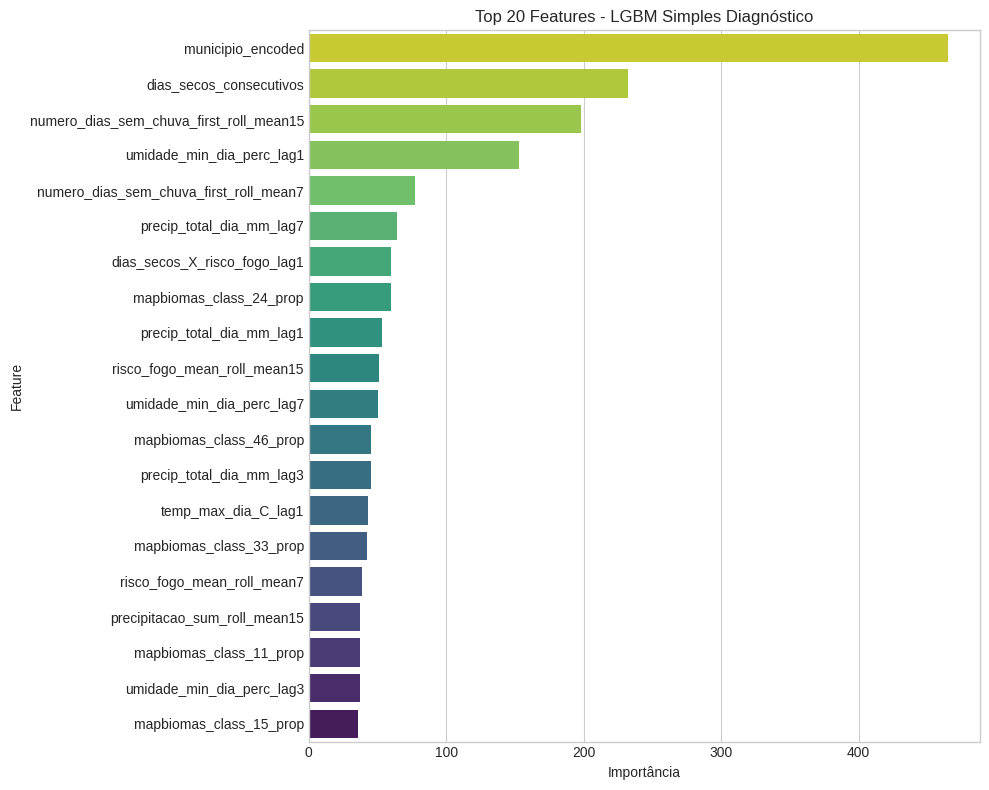

Fim do Diagnóstico


In [ ]:
print("\nBloco 6: Diagnóstico do LightGBM.")
counts_res_diag = pd.Series(y_treino_res).value_counts()
scale_pos_weight_diagnostic = counts_res_diag.get(0, 0) / counts_res_diag.get(1, 1) if counts_res_diag.get(1,1) > 0 else 1
lgbm_simple_diag = lgb.LGBMClassifier(
    random_state=42, n_estimators=100,
    scale_pos_weight=scale_pos_weight_diagnostic,
    objective='binary',
    n_jobs=-1
)
lgbm_simple_diag.fit(X_treino_res_df, y_treino_res,
                     eval_set=[(X_teste_scaled_df, y_teste)],
                     eval_metric='logloss',
                     callbacks=[lgb.early_stopping(10, verbose=0)])
num_features_used_diag = 0
if hasattr(lgbm_simple_diag, 'booster_') and lgbm_simple_diag.booster_:
    try: num_features_used_diag = lgbm_simple_diag.booster_.num_feature()
    except Exception: pass
print(f"Número de features usadas pelo LGBM Diagnóstico: {num_features_used_diag}")
y_pred_simple_diag = lgbm_simple_diag.predict(X_teste_scaled_df)
y_proba_simple_diag = lgbm_simple_diag.predict_proba(X_teste_scaled_df)[:, 1]
print("\nRelatório de Classificação (LGBM Simples Diagnóstico - Limiar 0.5):")
print(classification_report(y_teste, y_pred_simple_diag, target_names=['Não Incêndio', 'Incêndio'], digits=3, zero_division=0))
print(f"AUC-ROC (LGBM Simples Diagnóstico): {roc_auc_score(y_teste, y_proba_simple_diag):.3f}")
if num_features_used_diag > 0 and hasattr(lgbm_simple_diag, 'feature_importances_'):
    importancias_diag = pd.Series(lgbm_simple_diag.feature_importances_, index=X_treino_res_df.columns).sort_values(ascending=False)
    plt.figure(figsize=(10, 8))
    sns.barplot(x=importancias_diag.nlargest(20).values, y=importancias_diag.nlargest(20).index, palette='viridis_r', hue=importancias_diag.nlargest(20).index, legend=False, dodge=False)
    plt.title('Top 20 Features - LGBM Simples Diagnóstico'); plt.xlabel('Importância'); plt.ylabel('Feature'); plt.tight_layout(); plt.show()
print("Fim do Diagnóstico")


# Bloco 7: Otimização com RandomizedSearchCV e Treinamento Final


Bloco 7: Otimização com RandomizedSearchCV e Treinamento Final.
Scale_pos_weight para otimização final: 2.50
Iniciando RandomizedSearchCV (otimizando para F2-score da classe Incêndio)...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Number of positive: 43007, number of negative: 107519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.238969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28247
[LightGBM] [Info] Number of data points in the train set: 150526, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.285711 -> initscore=-0.916305
[LightGBM] [Info] Start training from score -0.916305
[LightGBM] [Info] Number of positive: 43008, number of negative: 107519
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.222943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] T

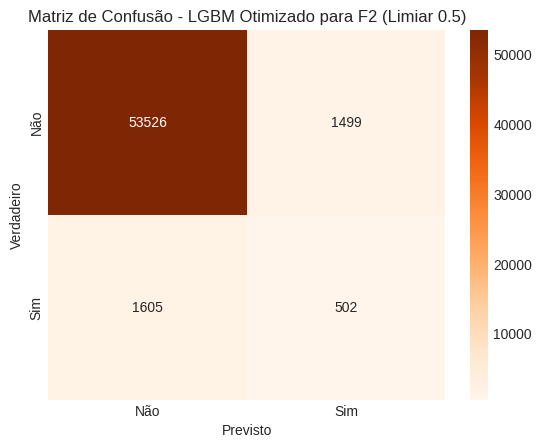

AUC-ROC: 0.785
AUC-PR: 0.198

Explorando Limiares de Decisão para Otimizar RECALL (Classe Incêndio) - Modelo Final:
Limiar | Recall | Precisão | F1-Score | F2-Score (Incêndio)
----------------------------------------------------------
 0.010 |  0.968 |    0.041 |    0.078 |    0.174
 0.015 |  0.958 |    0.044 |    0.083 |    0.184
 0.019 |  0.947 |    0.046 |    0.088 |    0.193
 0.024 |  0.937 |    0.048 |    0.092 |    0.201
 0.029 |  0.927 |    0.051 |    0.097 |    0.209
 0.034 |  0.916 |    0.053 |    0.101 |    0.216
 0.038 |  0.906 |    0.056 |    0.105 |    0.224
 0.043 |  0.892 |    0.058 |    0.109 |    0.230
 0.048 |  0.880 |    0.060 |    0.113 |    0.237
 0.053 |  0.868 |    0.063 |    0.117 |    0.243
 0.057 |  0.850 |    0.065 |    0.120 |    0.248
 0.062 |  0.838 |    0.067 |    0.124 |    0.254
 0.067 |  0.822 |    0.069 |    0.127 |    0.258
 0.072 |  0.805 |    0.071 |    0.130 |    0.262
 0.076 |  0.795 |    0.073 |    0.134 |    0.268
 0.081 |  0.777 |    0.075 |  

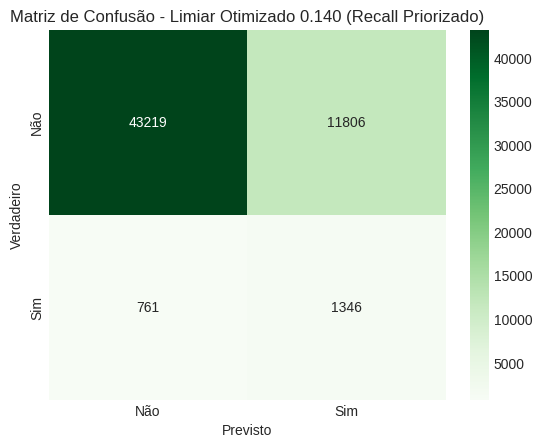


Número de features usadas pelo LGBM Otimizado Final: 115


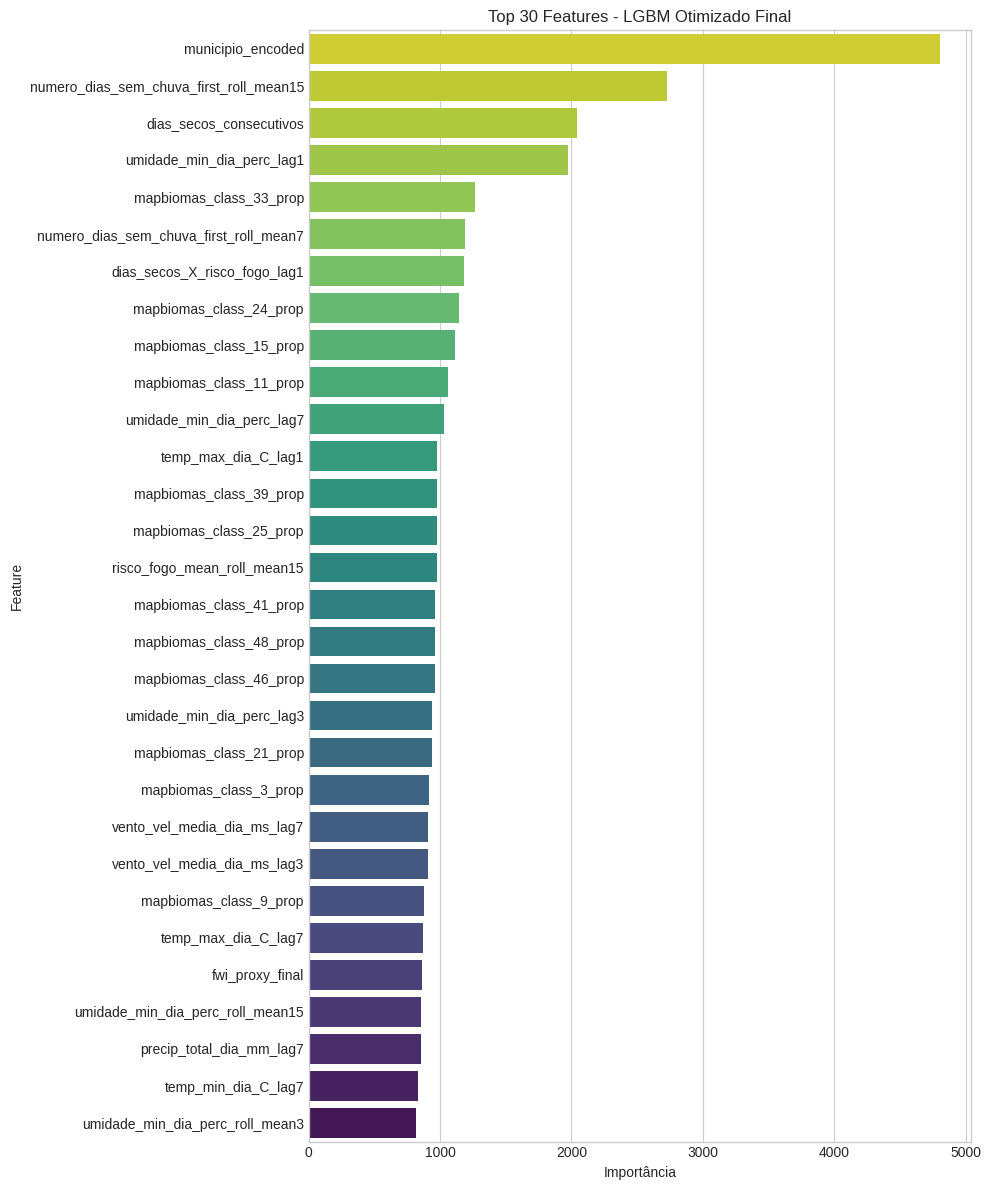


Modelo LightGBM Otimizado (foco no Recall) e transformadores salvos.
Fim do Script de ML


In [ ]:
print("\nBloco 7: Otimização com RandomizedSearchCV e Treinamento Final.")

scale_pos_weight_value_final = pd.Series(y_treino_res).value_counts().get(0,0) / pd.Series(y_treino_res).value_counts().get(1,1) if pd.Series(y_treino_res).value_counts().get(1,1) > 0 else 1
print(f"Scale_pos_weight para otimização final: {scale_pos_weight_value_final:.2f}")

param_dist_lgbm = {
    'n_estimators': [300, 500, 800],
    'learning_rate': [0.02, 0.05, 0.1],
    'num_leaves': [30, 50, 70, 90],
    'max_depth': [10, 15, -1],
    'min_child_samples': [20, 30, 50],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.2],
    'reg_lambda': [0, 0.1, 0.2],
    'boosting_type': ['gbdt'],
    'scale_pos_weight': [scale_pos_weight_value_final, round(scale_pos_weight_value_final * 1.25, 1), round(scale_pos_weight_value_final * 1.5, 1)]
}
cv_stratified = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1, zero_division=0)

lgbm_random_search = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42, n_jobs=-1, objective='binary'),
    param_distributions=param_dist_lgbm,
    n_iter=12,
    cv=cv_stratified,
    scoring=f2_scorer,
    verbose=1,
    random_state=42,
    n_jobs=1
)
print("Iniciando RandomizedSearchCV (otimizando para F2-score da classe Incêndio)...")
lgbm_random_search.fit(X_treino_res_df, y_treino_res)

print("\nMelhores hiperparâmetros encontrados (otimizados para F2-score):", lgbm_random_search.best_params_)
best_lgbm_clf_final = lgbm_random_search.best_estimator_

y_pred_lgbm_best_final_thresh_05 = best_lgbm_clf_final.predict(X_teste_scaled_df)
y_proba_lgbm_best_final = best_lgbm_clf_final.predict_proba(X_teste_scaled_df)[:, 1]

print("\nRelatório de Classificação (LightGBM Otimizado para F2 - Limiar 0.5):")
print(classification_report(y_teste, y_pred_lgbm_best_final_thresh_05, target_names=['Não Incêndio', 'Incêndio'], digits=3, zero_division=0))
cm_lgbm_best_final_thresh_05 = confusion_matrix(y_teste, y_pred_lgbm_best_final_thresh_05)
sns.heatmap(cm_lgbm_best_final_thresh_05, annot=True, fmt='d', cmap='Oranges', xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
plt.ylabel('Verdadeiro'); plt.xlabel('Previsto'); plt.title('Matriz de Confusão - LGBM Otimizado para F2 (Limiar 0.5)'); plt.show()
print(f"AUC-ROC: {roc_auc_score(y_teste, y_proba_lgbm_best_final):.3f}")
precision_lgbm_best_final, recall_lgbm_best_final, thresholds_pr_final = precision_recall_curve(y_teste, y_proba_lgbm_best_final)
print(f"AUC-PR: {auc(recall_lgbm_best_final, precision_lgbm_best_final):.3f}")

print("\nExplorando Limiares de Decisão para Otimizar RECALL (Classe Incêndio) - Modelo Final:")
best_recall_thresh = 0.0; max_recall_val = 0.0; precision_at_max_recall = 0.0; f1_at_max_recall = 0.0; f2_at_max_recall_val = 0.0
test_thresholds = np.concatenate([
    np.linspace(0.01, 0.1, num=19, endpoint=False),
    np.linspace(0.1, 0.4, num=31)
])
test_thresholds = np.sort(np.unique(test_thresholds))


print("Limiar | Recall | Precisão | F1-Score | F2-Score (Incêndio)")
print("----------------------------------------------------------")
MIN_PRECISION_DESEJADA = 0.10

for thresh in test_thresholds:
    if thresh < 1.0 and thresh > 0.0:
        y_pred_thresh = (y_proba_lgbm_best_final >= thresh).astype(int)
        current_recall = recall_score(y_teste, y_pred_thresh, pos_label=1, zero_division=0)
        current_precision = precision_score(y_teste, y_pred_thresh, pos_label=1, zero_division=0)
        current_f1 = f1_score(y_teste, y_pred_thresh, pos_label=1, zero_division=0)
        current_f2 = fbeta_score(y_teste, y_pred_thresh, beta=2, pos_label=1, zero_division=0)
        print(f"{thresh:6.3f} | {current_recall:6.3f} | {current_precision:8.3f} | {current_f1:8.3f} | {current_f2:8.3f}")

        # Critério: Maximizar recall, desde que a precisão seja aceitável E F2 melhore
        if current_precision >= MIN_PRECISION_DESEJADA:
            if current_recall > max_recall_val: # Prioriza o maior recall
                max_recall_val = current_recall
                precision_at_max_recall = current_precision
                f1_at_max_recall = current_f1
                f2_at_max_recall_val = current_f2
                best_recall_thresh = thresh
            elif current_recall == max_recall_val and current_f2 > f2_at_max_recall_val: # Se o recall for igual, desempate pelo F2
                precision_at_max_recall = current_precision
                f1_at_max_recall = current_f1
                f2_at_max_recall_val = current_f2
                best_recall_thresh = thresh
print("----------------------------------------------------------")
print(f"Melhor limiar (maximizando Recall com Precisão >= {MIN_PRECISION_DESEJADA}): {best_recall_thresh:.3f}")
print(f"  Com este limiar -> Recall (Incêndio): {max_recall_val:.3f}, Precisão (Incêndio): {precision_at_max_recall:.3f}, F1 (Incêndio): {f1_at_max_recall:.3f}, F2 (Incêndio): {f2_at_max_recall_val:.3f}")

y_pred_lgbm_best_recall_thresh = (y_proba_lgbm_best_final >= best_recall_thresh).astype(int)
print("\nRelatório com Melhor Limiar (Otimizado para Recall com restrição de Precisão):")
print(classification_report(y_teste, y_pred_lgbm_best_recall_thresh, target_names=['Não Incêndio', 'Incêndio'], digits=3, zero_division=0))
cm_lgbm_best_recall_thresh = confusion_matrix(y_teste, y_pred_lgbm_best_recall_thresh)
sns.heatmap(cm_lgbm_best_recall_thresh, annot=True, fmt='d', cmap='Greens', xticklabels=['Não', 'Sim'], yticklabels=['Não', 'Sim'])
plt.ylabel('Verdadeiro'); plt.xlabel('Previsto'); plt.title(f'Matriz de Confusão - Limiar Otimizado {best_recall_thresh:.3f} (Recall Priorizado)'); plt.show()

num_features_used_final = 0
if hasattr(best_lgbm_clf_final, 'booster_') and best_lgbm_clf_final.booster_:
    try: num_features_used_final = best_lgbm_clf_final.booster_.num_feature()
    except Exception: pass
print(f"\nNúmero de features usadas pelo LGBM Otimizado Final: {num_features_used_final}")

if num_features_used_final > 0 and hasattr(best_lgbm_clf_final, 'feature_importances_') and len(X_treino_res_df.columns) > 0 :
    importancias_lgbm_best_final = pd.Series(best_lgbm_clf_final.feature_importances_, index=X_treino_res_df.columns).sort_values(ascending=False)
    top_n_features_plot_final = 30
    plt.figure(figsize=(10, max(8, min(len(importancias_lgbm_best_final), top_n_features_plot_final) * 0.4)))
    sns.barplot(x=importancias_lgbm_best_final.nlargest(top_n_features_plot_final).values, y=importancias_lgbm_best_final.nlargest(top_n_features_plot_final).index, palette='viridis_r', hue=importancias_lgbm_best_final.nlargest(top_n_features_plot_final).index, legend=False, dodge=False)
    plt.title(f'Top {top_n_features_plot_final} Features - LGBM Otimizado Final')
    plt.xlabel('Importância'); plt.ylabel('Feature'); plt.tight_layout(); plt.show()

joblib.dump(best_lgbm_clf_final, 'modelo_incendio_lgbm_recall_focus.joblib')
joblib.dump(scaler, 'scaler_incendio_recall_focus.joblib')
joblib.dump(encoder_target_municipio, 'target_encoder_municipio_recall_focus.joblib')
joblib.dump(imputadores_finais, 'imputadores_finais_recall_focus.joblib')
joblib.dump(colunas_modelo_final, 'colunas_modelo_final_lista_recall_focus.joblib')
print("\nModelo LightGBM Otimizado (foco no Recall) e transformadores salvos.")
print("Fim do Script de ML")

In [ ]:
!pip freeze > requirements.txt